<a href="https://colab.research.google.com/github/Boliang312/Deep-Learning/blob/main/HW3_Chen_Boliang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [66]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data = df.filter(['Close'])
scaled_data = scaler.fit_transform(data)

# Function to create the dataset
def create_dataset(dataset, time_step):
    x_data, y_data = [], []
    for i in range(time_step, len(dataset)):
        x_data.append(dataset[i-time_step:i, 0])
        y_data.append(dataset[i, 0])
    return np.array(x_data), np.array(y_data)

In [67]:
# Function to build and train the model
def build_and_train_model(input_data, output_data, layers, batch_size, epochs=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_data.shape[1], 1)))
    for i in range(layers - 2):  # Adjusting for input and final dense layer
        model.add(LSTM(64, return_sequences=True if i < layers - 3 else False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs)
    return model

In [68]:
# Function to visualize the predictions
def visualize_predictions(train_data, valid_data, title):
    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data['Date'], train_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Close'])
    predictions = valid_data.dropna(subset=['Predictions'])
    plt.plot(predictions['Date'], predictions['Predictions'])

    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [69]:
# Define the start and end date for the test data
start_date = '2020-04-01'
end_date = '2020-07-09'
start_index = df.index[df['Date'] == pd.to_datetime(start_date)].tolist()[0]
end_index = df.index[df['Date'] == pd.to_datetime(end_date)].tolist()[0]


In [70]:
# Time steps, layer options and batch sizes to iterate over
time_steps = [1, 7, 14]
layer_options = [4, 6]
batch_sizes = [1, 32]

3/3 [==============================] - 1s 5ms/step


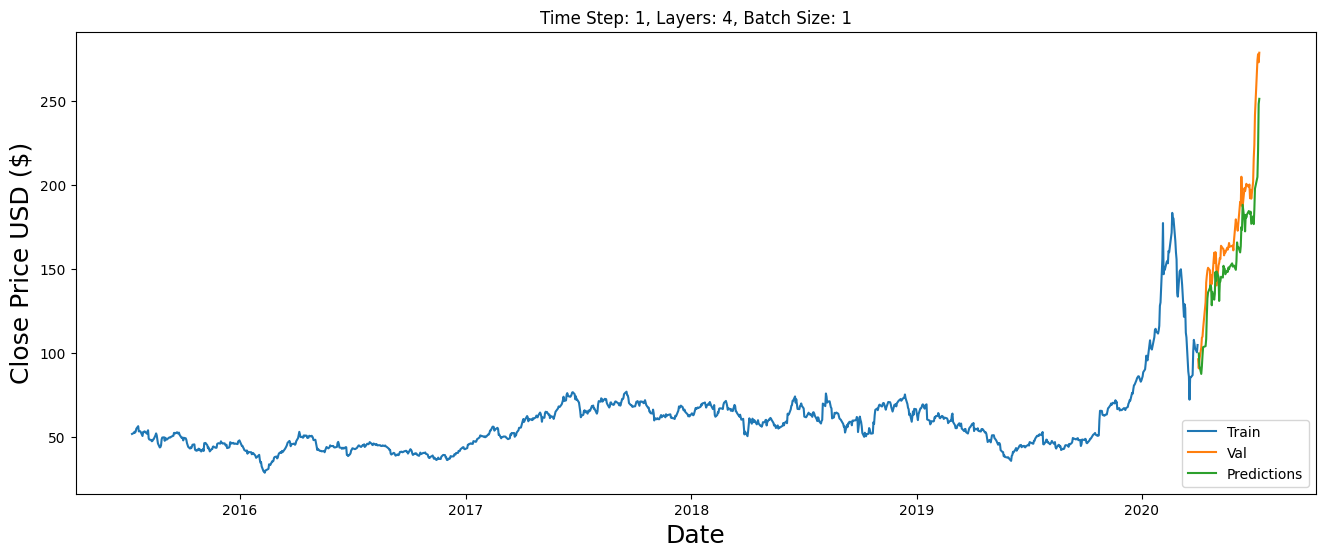

3/3 [==============================] - 1s 6ms/step


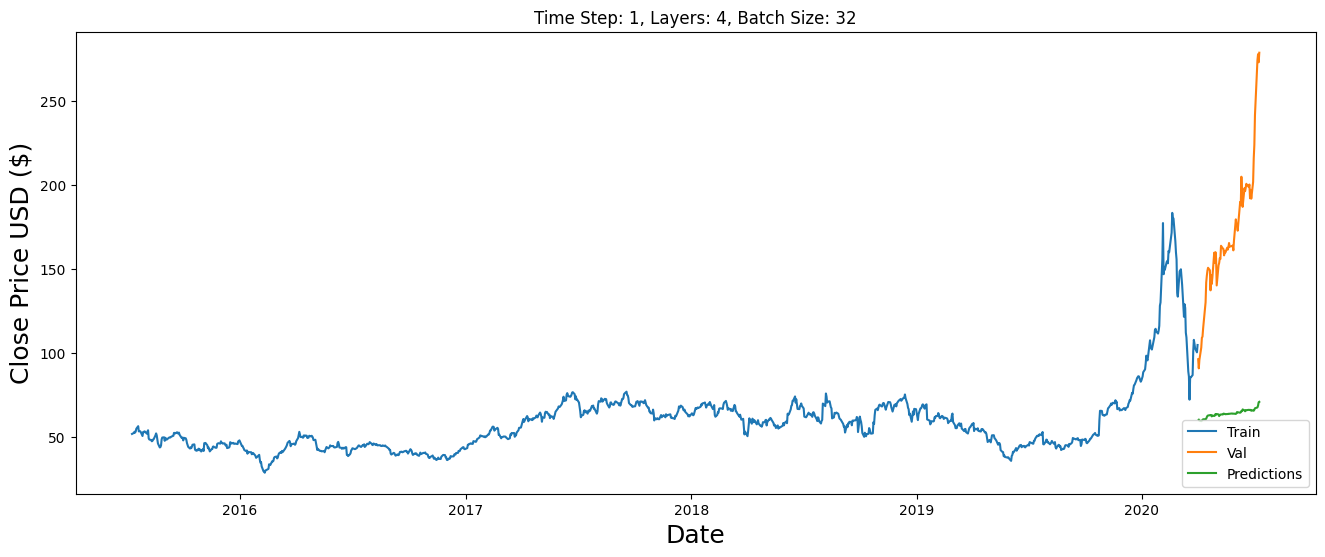

3/3 [==============================] - 1s 7ms/step


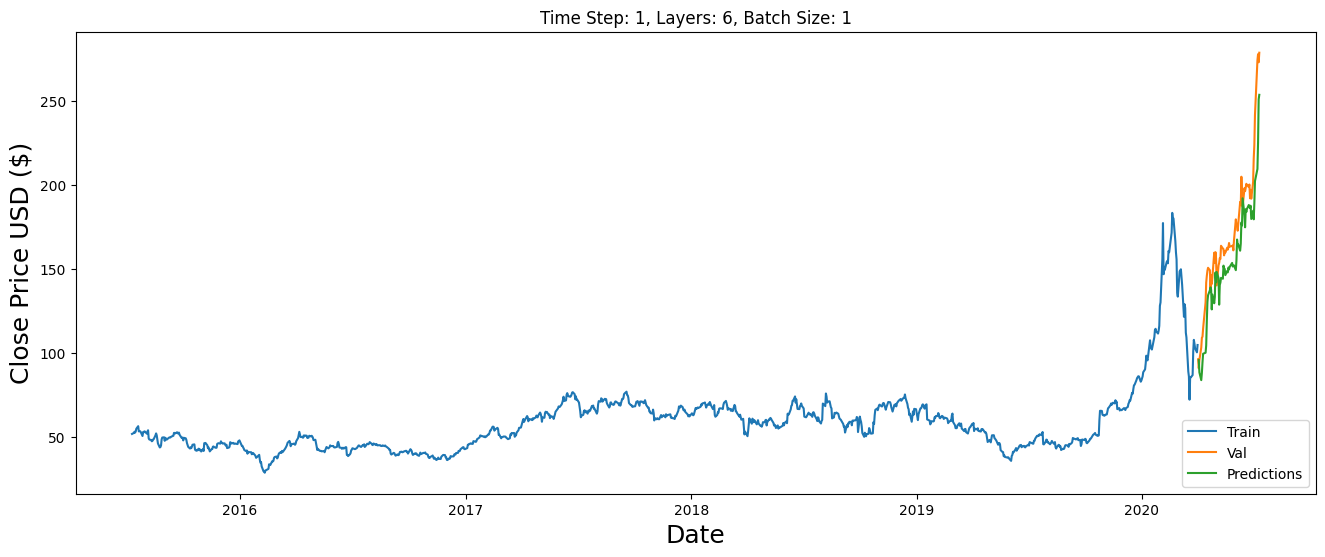

3/3 [==============================] - 1s 8ms/step


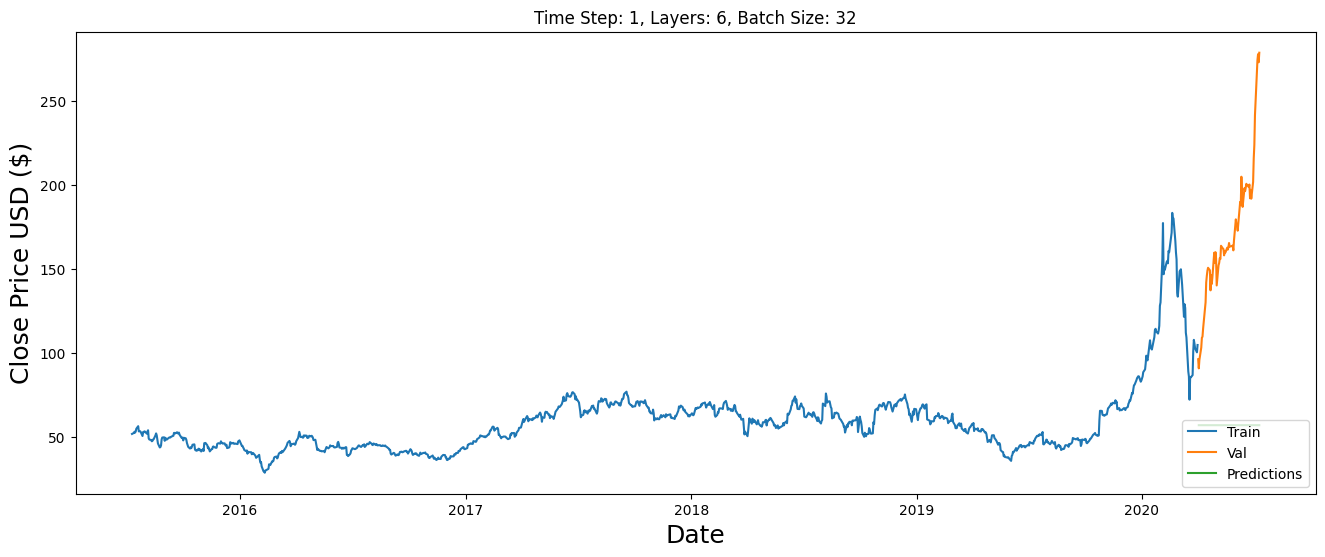

3/3 [==============================] - 1s 8ms/step


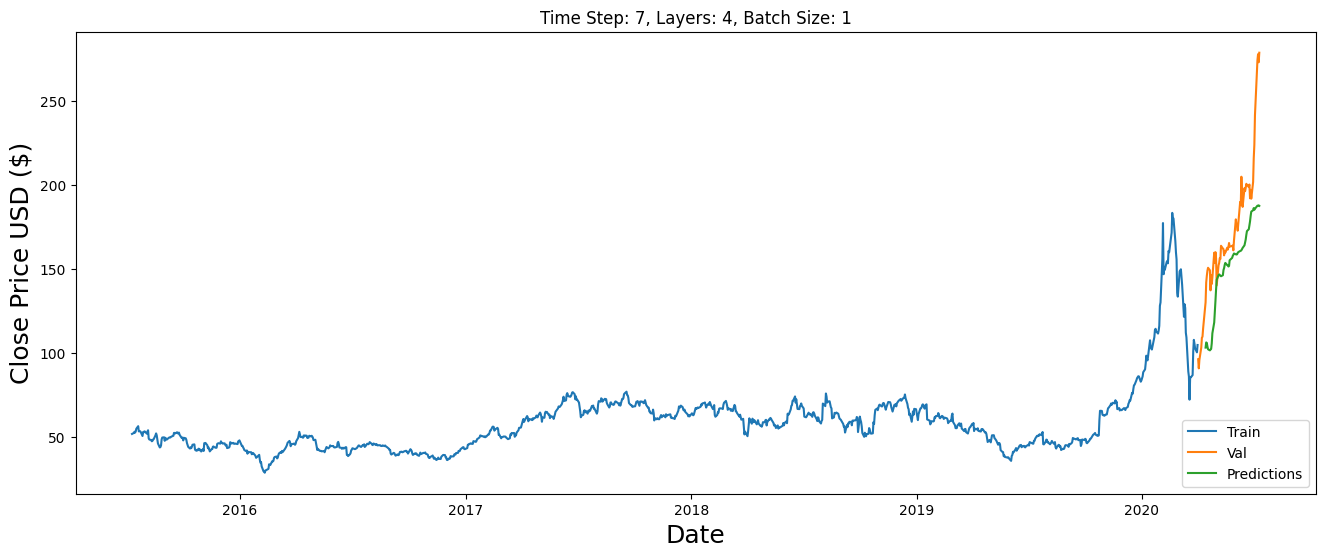

3/3 [==============================] - 1s 8ms/step


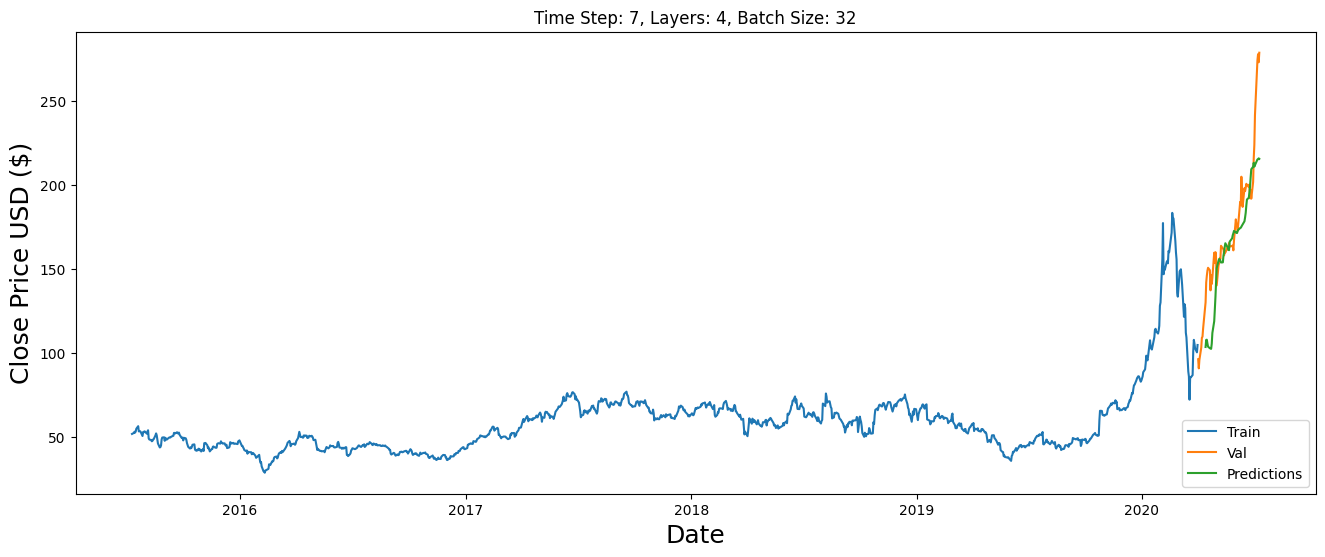

3/3 [==============================] - 2s 10ms/step


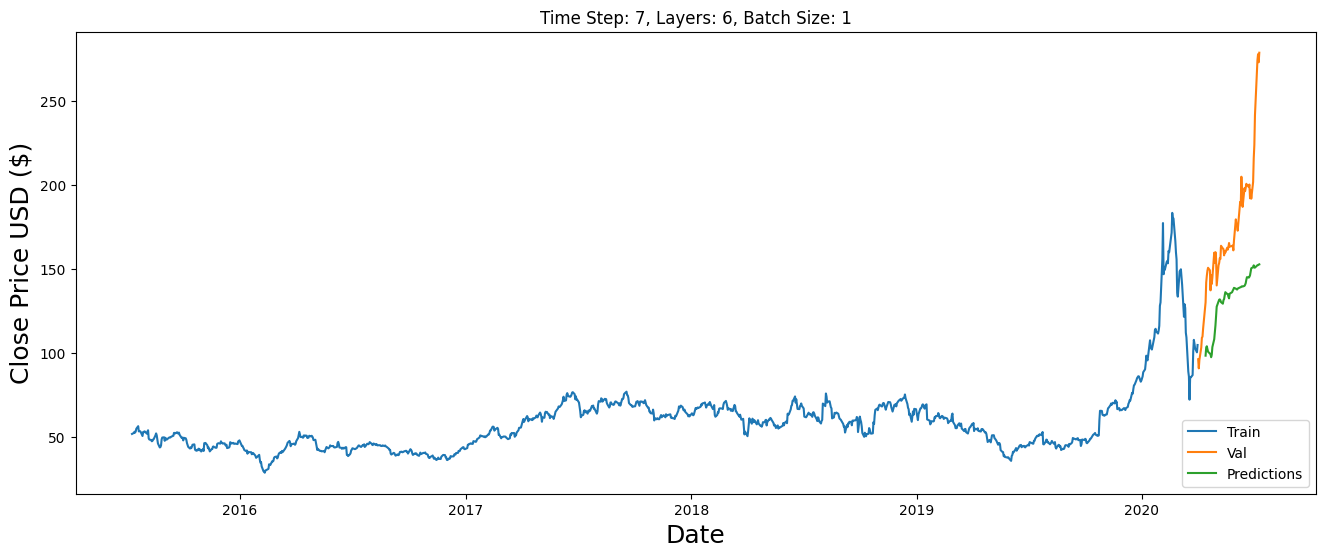

3/3 [==============================] - 2s 10ms/step


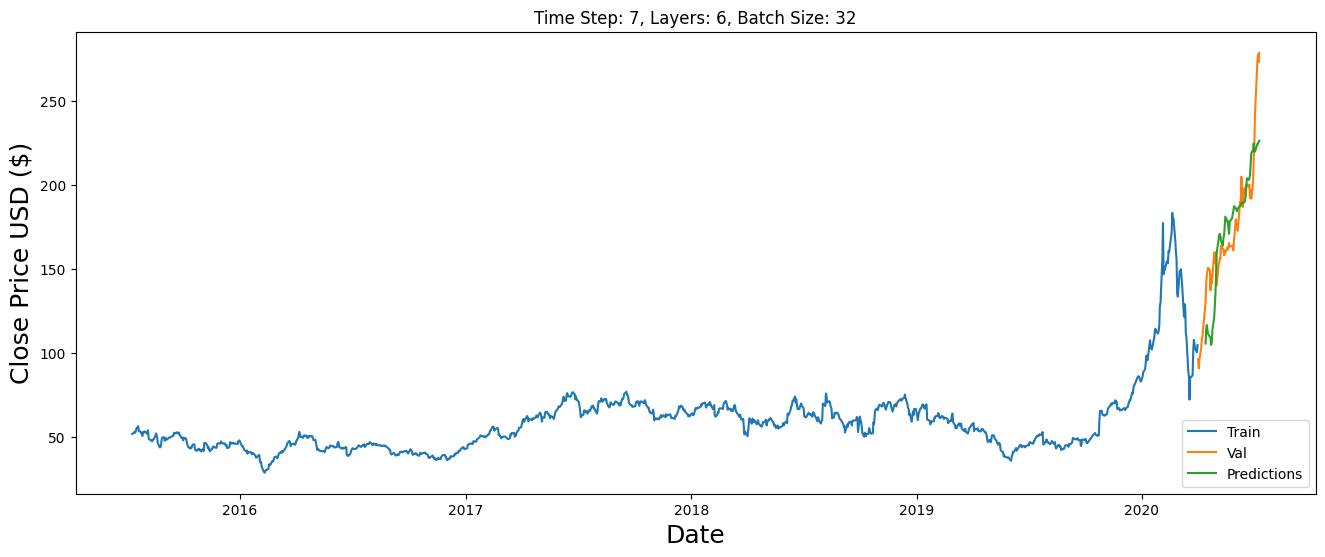

3/3 [==============================] - 1s 11ms/step


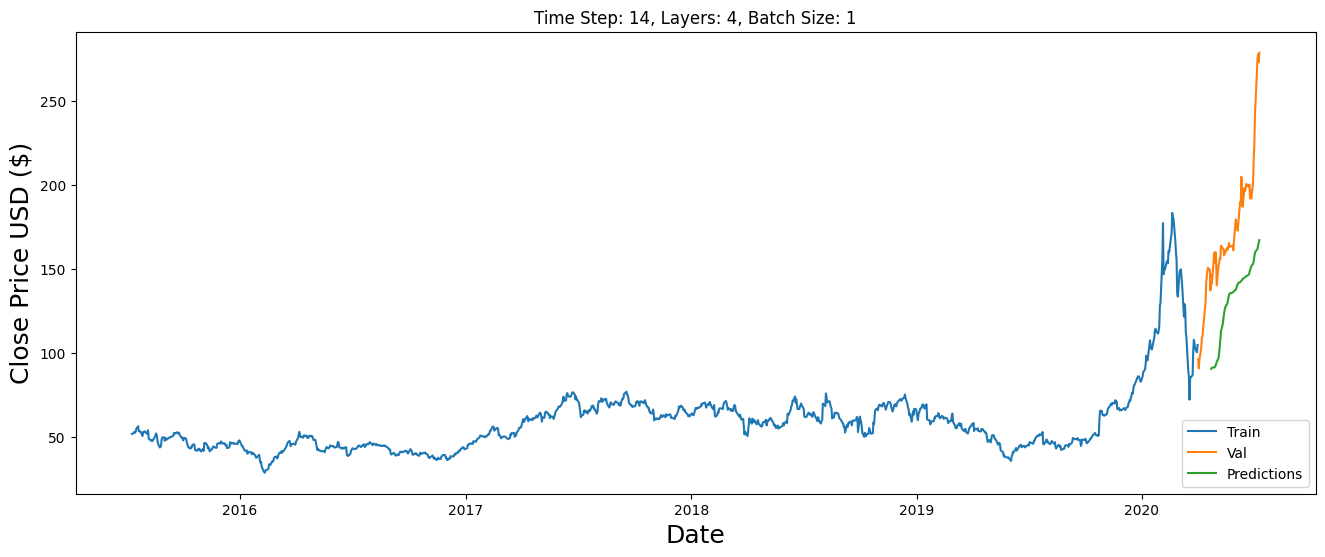

3/3 [==============================] - 1s 8ms/step


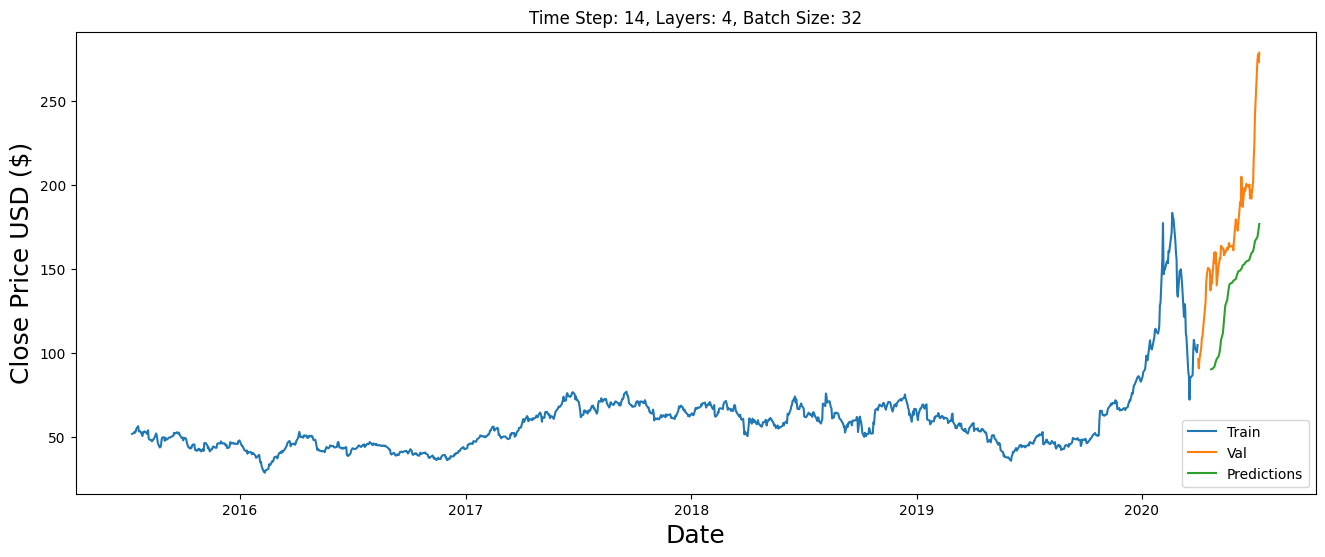

3/3 [==============================] - 2s 11ms/step


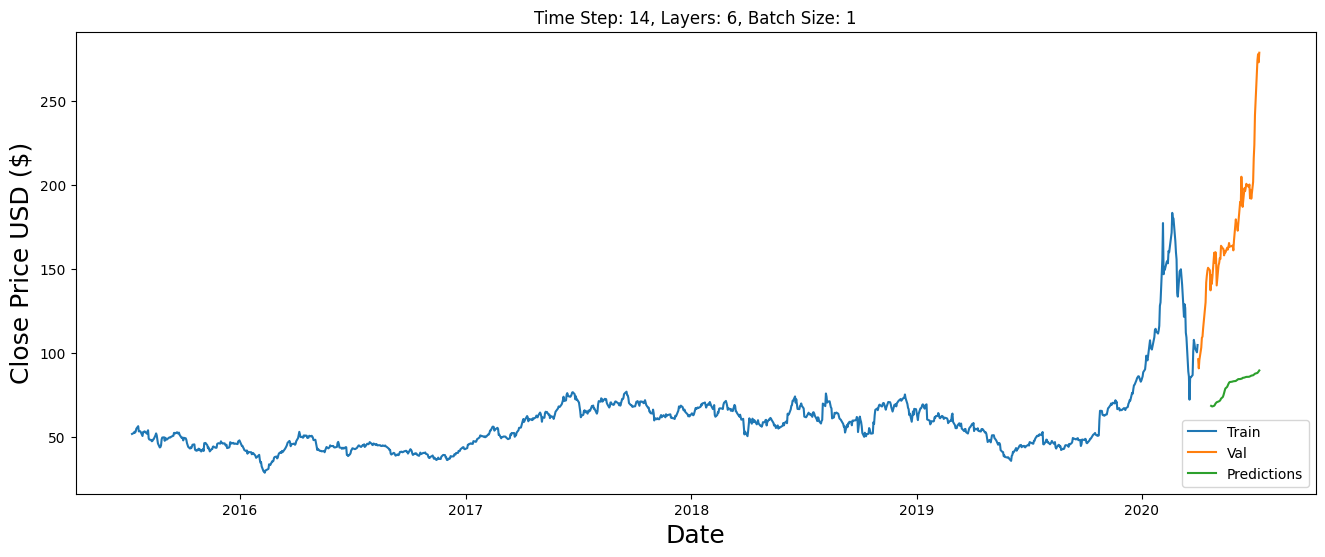

3/3 [==============================] - 2s 12ms/step


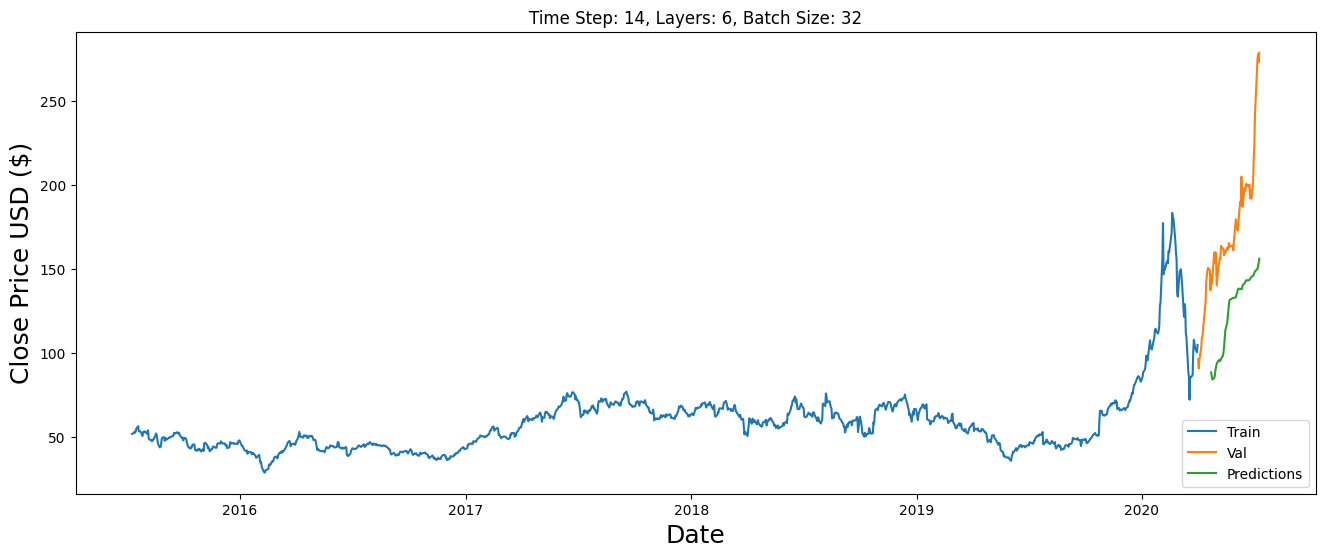

In [72]:
# Loop over time steps, layers, and batch sizes
for time_step in time_steps:
    for layers in layer_options:
        for batch_size in batch_sizes:
            # Create training and test data using the specified time_step
            train_data = scaled_data[:start_index, :]
            test_data = scaled_data[start_index - time_step:end_index+1, :]

            x_train, y_train = create_dataset(train_data, time_step)
            x_test, y_test = create_dataset(test_data, time_step)

            # Reshape the data to be 3D [samples, time steps, features] for LSTM
            x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

            # Build and train the model
            model = build_and_train_model(x_train, y_train, layers, batch_size, epochs=1)

            # Generate predictions
            predictions = model.predict(x_test)
            predictions = scaler.inverse_transform(predictions)

            # Prepare the train and valid datasets for plotting
            train = df[:start_index]
            valid = df[start_index:end_index+1]
            train = train.reset_index(drop=True)
            valid = valid.reset_index(drop=True)

            # Ensure 'Predictions' column exists in the 'valid' DataFrame
            valid['Predictions'] = np.nan  # This should be done every time after valid is defined

            # Calculate the correct indices in the valid DataFrame
            prediction_length = min(len(predictions), len(valid) - time_step)
            valid_indices = list(range(time_step, time_step + prediction_length))

            # Ensure that the predictions are being assigned to the correct location
            valid.loc[valid_indices, 'Predictions'] = predictions[:prediction_length].flatten()

            # Visualize the results
            title = f"Time Step: {time_step}, Layers: {layers}, Batch Size: {batch_size}"
            visualize_predictions(train, valid, title)

In [63]:
#From the picture, we can see the model with 1day, 4 layers, 1 batch size is the best model.
#So we choose this one to do the future prediction.

1/1 [==============================] - 1s 1s/step


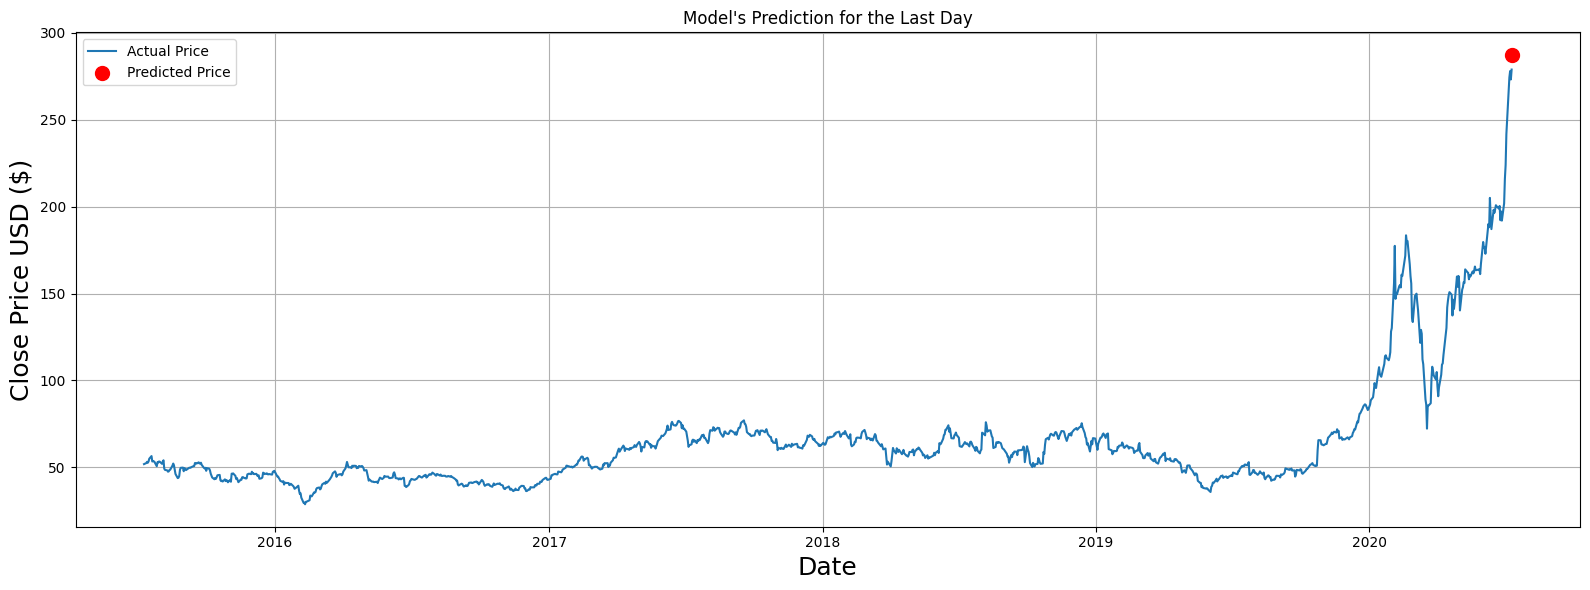

In [73]:
# Prepare the data for training with entire dataset except the last day
time_step = 1  # 1 day time step
layers = 4  # 4 layers
batch = 1  # batch size of 1

training_data_len = len(scaled_data) - 1  # Exclude the last day
train_data = scaled_data[0:training_data_len, :]

# Create datasets using the time_step
x_train, y_train = create_dataset(train_data, time_step)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the model with specified parameters
model = build_and_train_model(x_train, y_train, layers, batch, epochs=1)

# Prepare the data for predicting the last day's price
last_day_data = scaled_data[-time_step-1:-1].reshape(1, time_step, 1)

# Predict the last day's price
predicted_price = model.predict(last_day_data)
predicted_price = scaler.inverse_transform(predicted_price)

# Visualize the real stock prices and the predicted price for the last day
def visualize_last_day_prediction(actual_data, predicted_price):
    plt.figure(figsize=(16, 6))
    plt.title("Model's Prediction for the Last Day")
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(actual_data['Date'], actual_data['Close'])

    # Highlight the predicted price for the last day
    plt.scatter(actual_data['Date'].iloc[-1], predicted_price, color='red', label='Predicted Price', s=100, zorder=5)

    plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Use the function to visualize the result
visualize_last_day_prediction(df, predicted_price[0][0])

1/1 [==============================] - 1s 1s/step


<ipython-input-74-687d1ed2b33d>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


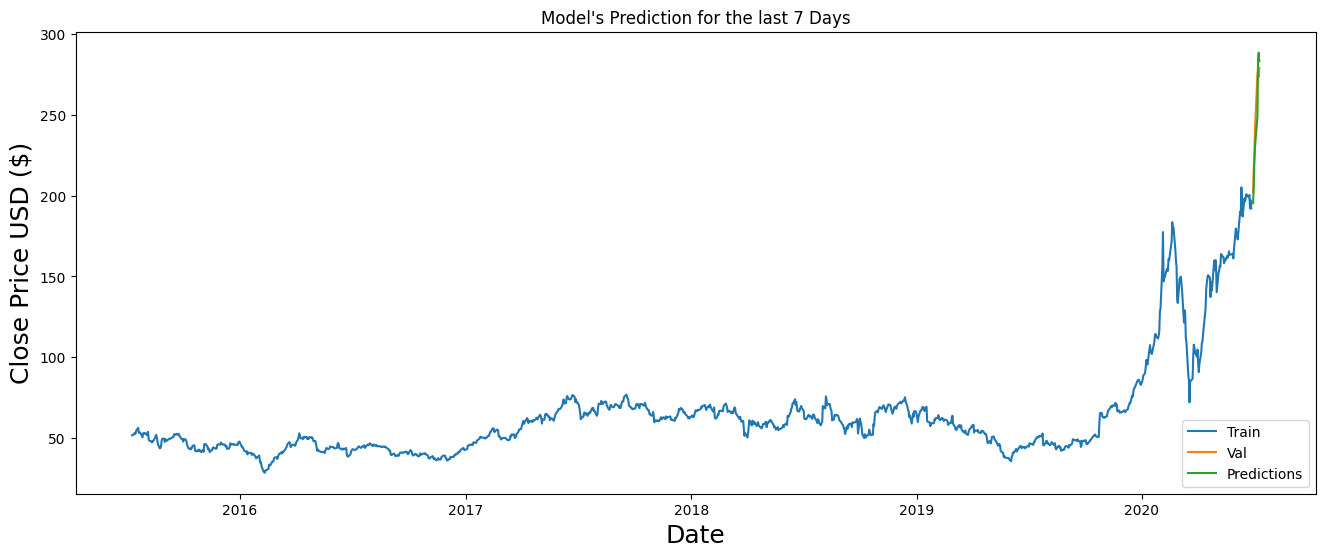

In [74]:
# Prepare the data for training with entire dataset except the last day
time_step = 1  # 1 day time step
layers = 4  # 4 layers
batch = 1  # batch size of 1

# Use all data except the last 8 days to train
training_data_len = len(scaled_data) - 8
train_data = scaled_data[0:training_data_len, :]

# Create the datasets
x_train, y_train = create_dataset(train_data, 1) # Using a 1-day lag

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the model
model = build_and_train_model(x_train, y_train, 4, 1, epochs=1)

# Use the last 8 days of the scaled data for prediction (1 day for input + 7 days for prediction)
x_test = scaled_data[training_data_len-1:-1, :]

# Reshape x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

train = df[:training_data_len]
valid = df[training_data_len:]
valid.reset_index(drop=True, inplace=True)
valid['Predictions'] = predictions

def visualize_predictions(train_data, valid_data, title):
    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data['Date'], train_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Predictions'])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

# Visualize the results
visualize_predictions(train, valid, "Model's Prediction for the last 7 Days")

1/1 [==============================] - 1s 943ms/step


<ipython-input-75-f9e544dd25df>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


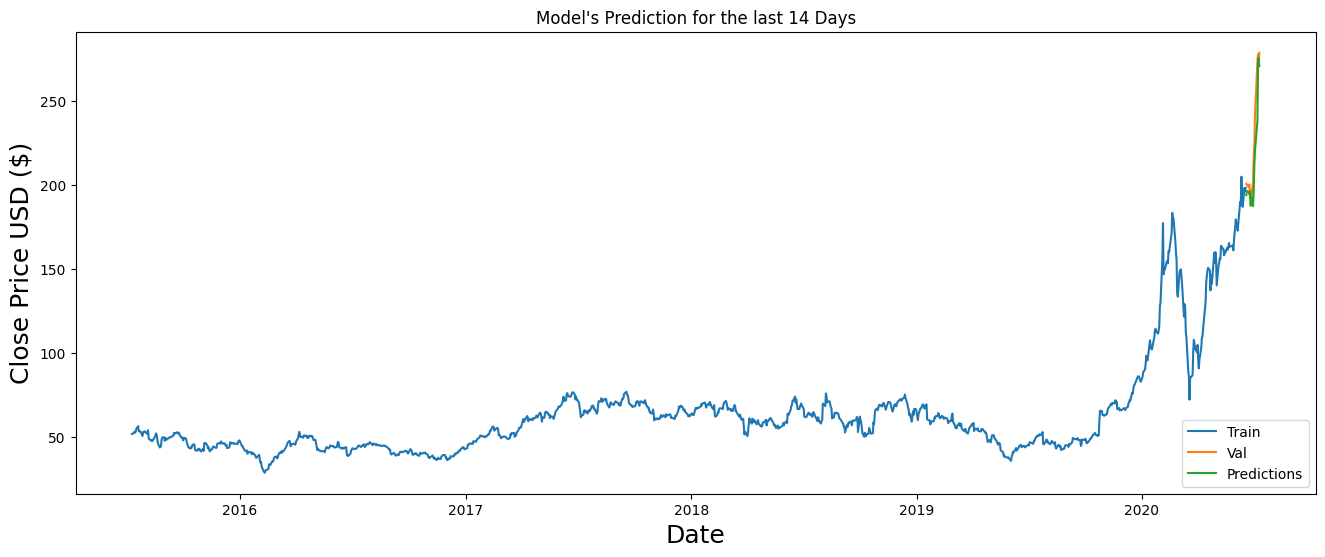

In [75]:
# Prepare the data for training with entire dataset except the last day
time_step = 1  # 1 day time step
layers = 4  # 4 layers
batch = 1  # batch size of 1

# Use all data except the last 15 days to train
training_data_len = len(scaled_data) - 15
train_data = scaled_data[0:training_data_len, :]

# Create the datasets
x_train, y_train = create_dataset(train_data, 1) # Using a 1-day lag

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the model
model = build_and_train_model(x_train, y_train, 4, 1, epochs=1)

# Use the last 8 days of the scaled data for prediction (1 day for input + 14 days for prediction)
x_test = scaled_data[training_data_len-1:-1, :]

# Reshape x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

train = df[:training_data_len]
valid = df[training_data_len:]
valid.reset_index(drop=True, inplace=True)
valid['Predictions'] = predictions

def visualize_predictions(train_data, valid_data, title):
    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data['Date'], train_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Predictions'])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

# Visualize the results
visualize_predictions(train, valid, "Model's Prediction for the last 14 Days")